## Reliance Industries

### Installing and importing libraries

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

plt.style.use('ggplot')
#expand the no of columns that are displayed
pd.set_option('display.max_columns',200)

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install keras

In [25]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [4]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

### Importing the data

In [5]:
import yfinance as yf
df = yf.download('RELIANCE.NS',start="2015-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


### Processing the data

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
df['Normalized'] = scaler.fit_transform(df['Close'])

In [64]:
training_set = df[:'2023']
test_set = df['2024':]

In [ ]:
training_set_scaled = scaler.fit_transform(training_set['Close'])

### Decomposition of data into its components

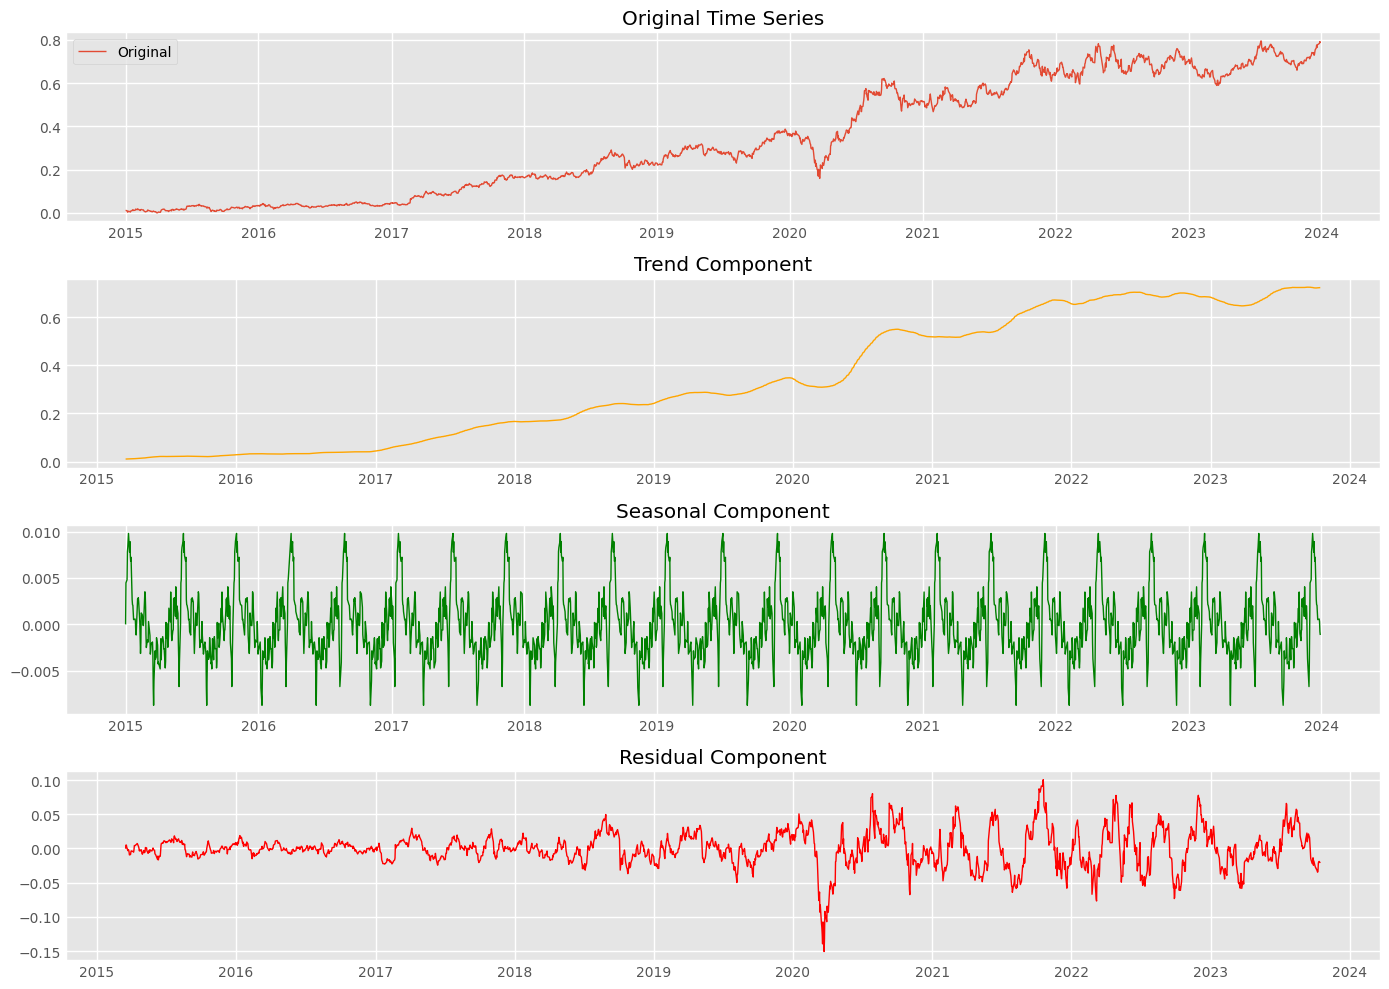

In [66]:
res = seasonal_decompose(training_set['Normalized'], period=100, model="additive") # Here, 100 is obtained by first differencing and then observing peak in ACF plot.

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(training_set['Normalized'], label="Original", linewidth = 1)
plt.title("Original Time Series")
plt.legend()

plt.subplot(412)
plt.plot(res.trend, color='orange', linewidth = 1)
plt.title("Trend Component")

plt.subplot(413)
plt.plot(res.seasonal, color='green', linewidth = 1)
plt.title("Seasonal Component")

plt.subplot(414)
plt.plot(res.resid, color='red', linewidth = 1)
plt.title("Residual Component")

plt.tight_layout()
plt.show()

### Plotting the time series

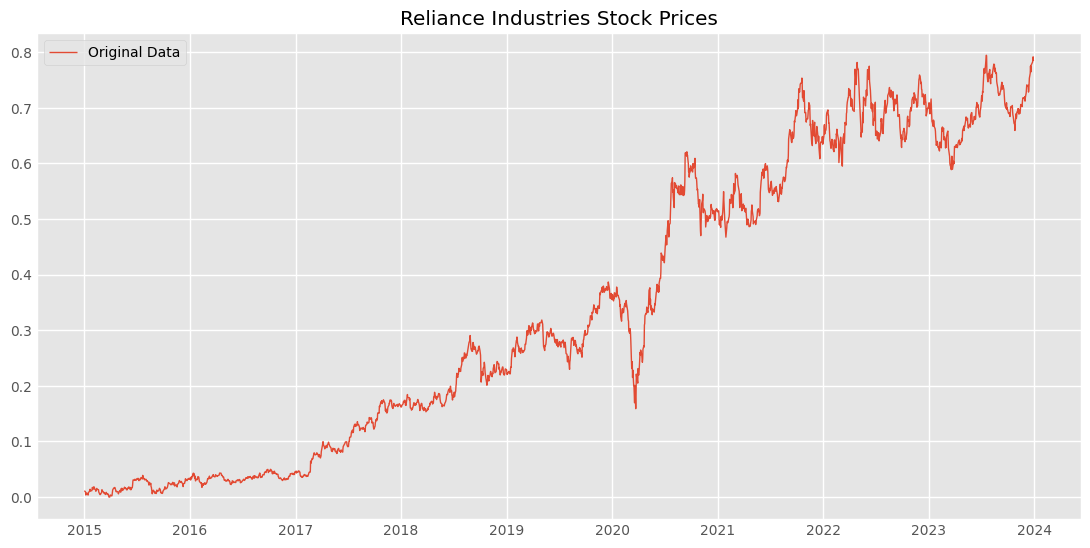

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(training_set['Normalized'], label="Original Data", linewidth = 1)
plt.title("Reliance Industries Stock Prices")
plt.legend()
plt.show()

### Checking Stationarity

In [68]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
check_stationarity(training_set['Normalized'])

ADF Statistic: -0.37930946535770316
p-value: 0.9134964610296951
The series is not stationary.


In [69]:
# Differencing the testing data
test_diff = test_set['Normalized'].diff(100).dropna()

In [71]:
# If not stationary, perform differencing
# Differencing the training data
data_diff = training_set['Normalized'].diff(100).dropna()

In [72]:
check_stationarity(data_diff)
check_stationarity(test_diff) # Despite being non-stationary, the test_set is not big enough to perform 100 differencing
# if differencing of train_Set is changed to something to make test_set stationary then log likelihood of arima model
# reduces drastically

ADF Statistic: -5.3079269395018365
p-value: 5.272381019715792e-06
The series is stationary.
ADF Statistic: -1.2177634557299937
p-value: 0.665908026014771
The series is not stationary.


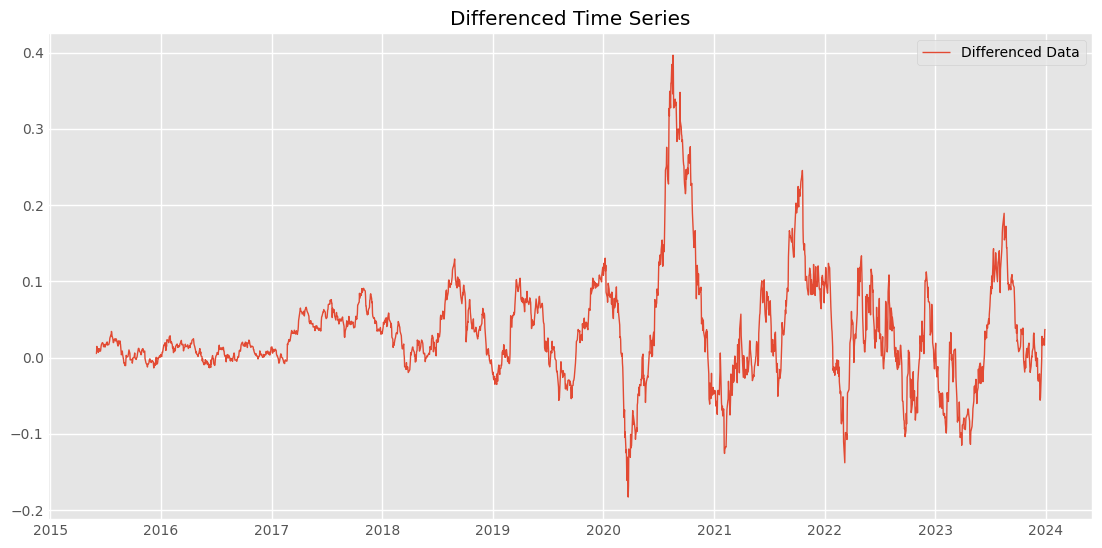

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(data_diff, label="Differenced Data", linewidth = 1)
plt.title("Differenced Time Series")
plt.legend()
plt.show()

### ACF and PACF Plots

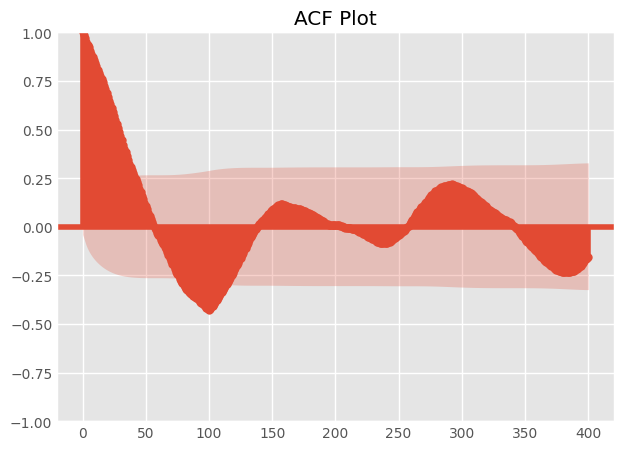

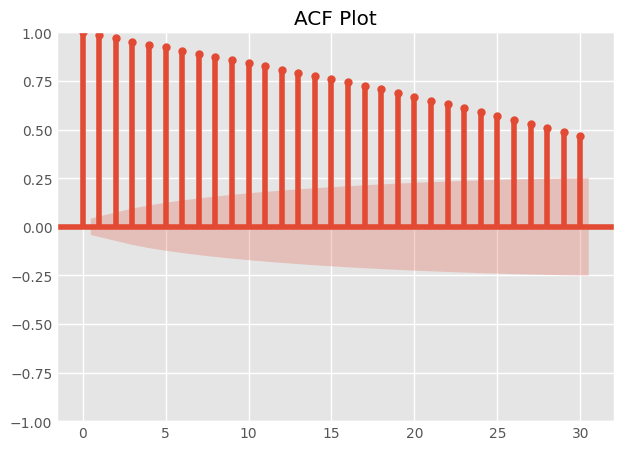

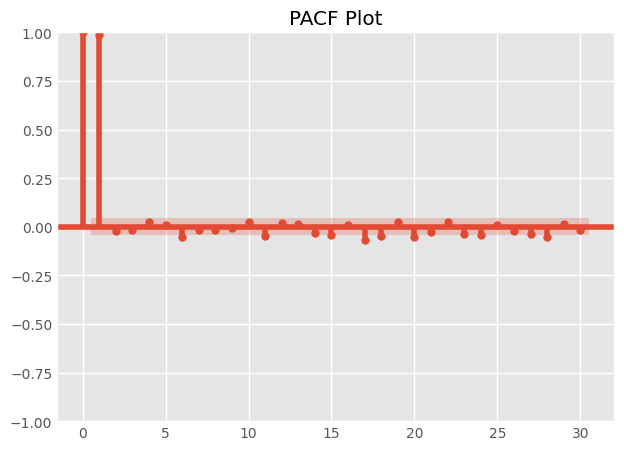

In [74]:
plot_acf(data_diff, lags=400) # from here, i obtained d=100, observe the peak at 100
plt.title("ACF Plot")
plt.show()

plot_acf(data_diff, lags=30)
plt.title("ACF Plot")
plt.show()

plot_pacf(data_diff, lags=30)
plt.title("PACF Plot")
plt.show()

In [75]:
data_diff = data_diff.asfreq('B')
test_diff = test_diff.asfreq('B')
# setting the frequency of data as 'B' meaning business days
# and filling the NaN values thus created
data_diff = data_diff.fillna(method='ffill')
test_diff = test_diff.fillna(method='ffill')

In [76]:
# checking with arima the train_set
# with above pacf and acf values
arima_model = ARIMA(data_diff, order=(1,0,30))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Normalized   No. Observations:                 2240
Model:                ARIMA(1, 0, 30)   Log Likelihood                6725.388
Date:                Fri, 31 Jan 2025   AIC                         -13384.776
Time:                        12:54:00   BIC                         -13196.207
Sample:                    06-01-2015   HQIC                        -13315.934
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0327      0.017      1.971      0.049       0.000       0.065
ar.L1          0.9758      0.006    165.666      0.000       0.964       0.987
ma.L1          0.0331      0.018      1.825      0.068      -0.002       0.069
ma.L2          0.0092      0.018      0.509      0.611      -0.026       0.045
ma.L3         -0.0129      0.017     -0.754      0.451      -0.046       0.021
ma.L4         -0.0167      0.018     -0.920      0.358      -0.052       0.019
ma.L5          0.0733      0.018      4.181      0.000       0.039       0.108
ma.L6         -0.0135      0.017     -0.781      0.435      -0.047       0.020
ma.L7          0.0325      0.015      2.112      0.035       0.002       0.063
ma.L8          0.0104      0.017      0.609      0.543      -0.023       0.044
ma.L9          0.0106      0.016      0.672      0.501      -0.020       0.042
ma.L10         0.0197      0.017      1.162      0.245      -0.014       0.053
ma.L11        -0.0338      0.018     -1.902      0.057      -0.069       0.001
ma.L12         0.0226      0.017      1.311      0.190      -0.011       0.056
ma.L13         0.0318      0.017      1.867      0.062      -0.002       0.065
ma.L14         0.0141      0.017      0.820      0.412      -0.020       0.048
ma.L15         0.0258      0.018      1.441      0.150      -0.009       0.061
ma.L16         0.0361      0.015      2.452      0.014       0.007       0.065
ma.L17         0.0578      0.018      3.177      0.001       0.022       0.093
ma.L18         0.0098      0.018      0.556      0.578      -0.025       0.044
ma.L19        -0.0211      0.017     -1.242      0.214      -0.055       0.012
ma.L20         0.0530      0.017      3.059      0.002       0.019       0.087
ma.L21        -0.0242      0.018     -1.353      0.176      -0.059       0.011
ma.L22         0.1043      0.017      6.074      0.000       0.071       0.138
ma.L23        -0.0020      0.017     -0.115      0.909      -0.036       0.032
ma.L24         0.0188      0.017      1.119      0.263      -0.014       0.052
ma.L25         0.0307      0.017      1.786      0.074      -0.003       0.064
ma.L26         0.0049      0.017      0.286      0.775      -0.029       0.039
ma.L27         0.0102      0.018      0.553      0.580      -0.026       0.046
ma.L28         0.0187      0.017      1.085      0.278      -0.015       0.053
ma.L29         0.0207      0.018      1.177      0.239      -0.014       0.055
ma.L30         0.0180      0.018      1.009      0.313      -0.017       0.053
sigma2         0.0001   2.52e-06     57.091      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2341.29
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              17.19   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:       

In [85]:
residuals_train = arima_fit.resid # saving the arima model residuals for the train set

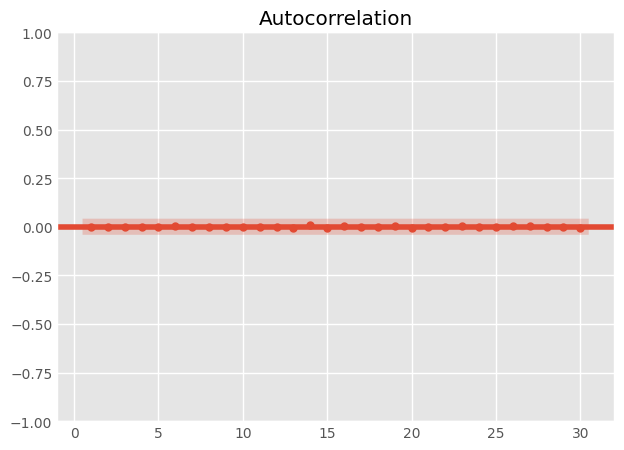

In [77]:
# analyzing residuals of arima
plot_acf(arima_fit.resid, zero=False,lags=30)
plt.show()

In [79]:
# predicting arima values
arima_pred = arima_fit.predict(start=data_diff.index[0], end=data_diff.index[-1], typ='levels')
arima_forecast = arima_fit.forecast(steps=153)
arima_forecast = pd.Series(arima_forecast.values, index=test_diff.index)

In [87]:
# arima model to get the residuals of the train_Set which will be required further
arima_model = ARIMA(test_diff, order=(1,0,30))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Normalized   No. Observations:                  153
Model:                ARIMA(1, 0, 30)   Log Likelihood                 387.491
Date:                Fri, 31 Jan 2025   AIC                           -708.981
Time:                        12:58:41   BIC                           -608.977
Sample:                    05-31-2024   HQIC                          -668.358
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0234      0.044     -0.530      0.596      -0.110       0.063
ar.L1          0.2503     37.770      0.007      0.995     -73.778      74.279
ma.L1          0.5853     37.779      0.015      0.988     -73.460      74.631
ma.L2          0.6726     31.562      0.021      0.983     -61.188      62.533
ma.L3          0.6227     33.309      0.019      0.985     -64.661      65.906
ma.L4          0.7295     31.863      0.023      0.982     -61.720      63.179
ma.L5          0.6533     35.548      0.018      0.985     -69.020      70.327
ma.L6          0.7647     33.590      0.023      0.982     -65.070      66.600
ma.L7          0.9111     37.322      0.024      0.981     -72.239      74.061
ma.L8          1.0238     43.753      0.023      0.981     -84.730      86.778
ma.L9          0.9296     49.639      0.019      0.985     -96.360      98.220
ma.L10         0.9316     47.558      0.020      0.984     -92.281      94.144
ma.L11         0.9315     47.127      0.020      0.984     -91.436      93.299
ma.L12         0.9204     47.017      0.020      0.984     -91.230      93.071
ma.L13         0.9355     46.572      0.020      0.984     -90.345      92.216
ma.L14         1.0258     47.064      0.022      0.983     -91.217      93.269
ma.L15         0.9668     50.578      0.019      0.985     -98.164     100.097
ma.L16         0.7829     49.242      0.016      0.987     -95.729      97.295
ma.L17         0.9043     41.963      0.022      0.983     -81.341      83.149
ma.L18         0.6350     44.743      0.014      0.989     -87.060      88.330
ma.L19         0.6099     35.272      0.017      0.986     -68.521      69.741
ma.L20         0.4905     31.943      0.015      0.988     -62.116      63.097
ma.L21         0.5838     26.607      0.022      0.982     -51.565      52.733
ma.L22         0.5215     28.794      0.018      0.986     -55.914      56.957
ma.L23         0.3084     26.992      0.011      0.991     -52.595      53.212
ma.L24         0.4947     18.474      0.027      0.979     -35.713      36.702
ma.L25         0.3952     23.398      0.017      0.987     -45.464      46.254
ma.L26         0.2177     20.880      0.010      0.992     -40.706      41.142
ma.L27         0.1905     13.532      0.014      0.989     -26.331      26.712
ma.L28         0.2050     10.627      0.019      0.985     -20.623      21.033
ma.L29         0.1148     10.493      0.011      0.991     -20.450      20.680
ma.L30        -0.0496      7.015     -0.007      0.994     -13.798      13.699
sigma2         0.0003   5.21e-05      6.673      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 5.43
Prob(Q):                              0.72   Prob(JB):                         0.07
Heteroskedasticity (H):               1.16   Skew:                            -0.12
Prob(H) (two-sided):                  0.60   Kurtosis:       

In [88]:
residuals_test = arima_fit.resid #saving arima residuals for the test_set

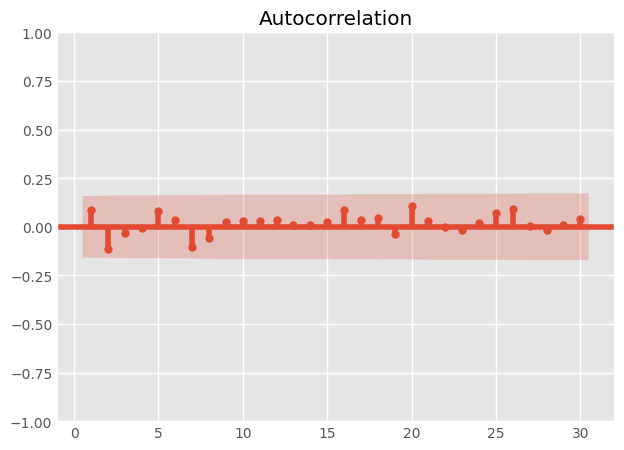

In [90]:
# analyzing residuals of arima
plot_acf(arima_fit.resid, zero=False,lags=30)
plt.show()

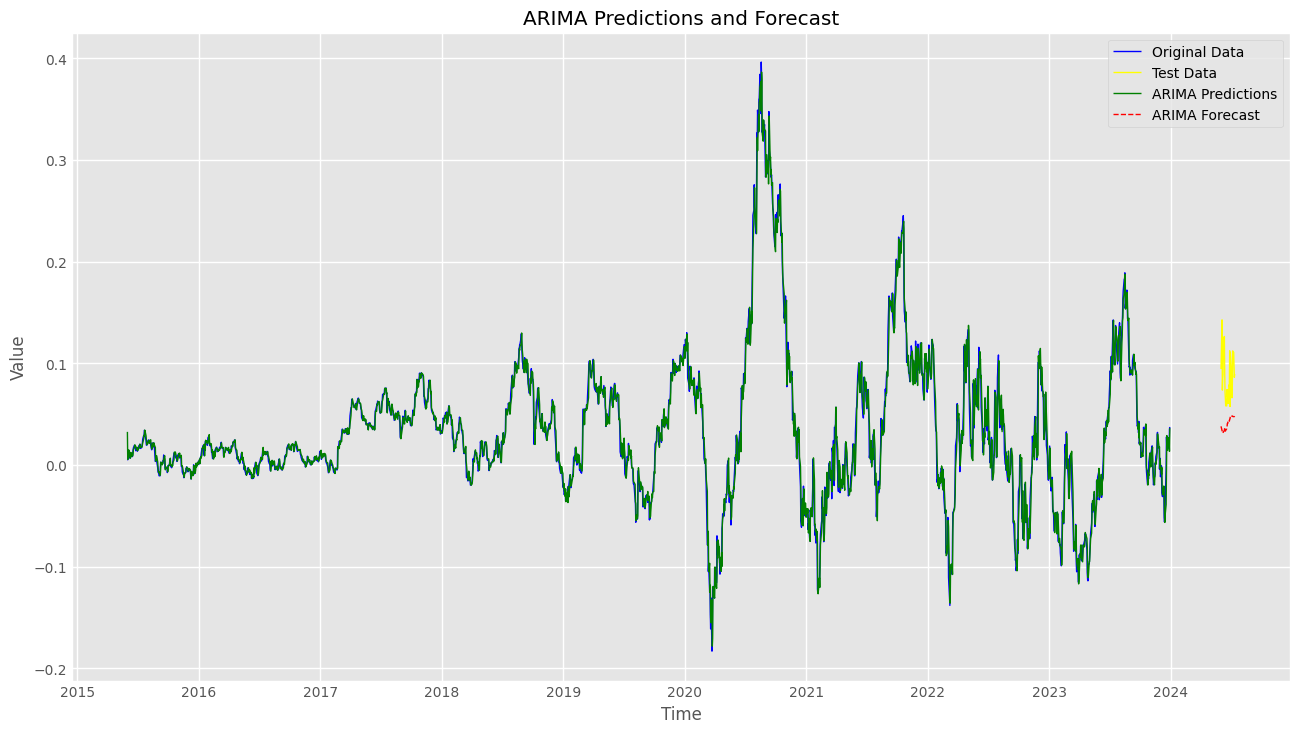

The calculated Root Mean Square Error (RMSE) is: 0.051691689970134395
The calculated Mean Absolute Error (MAE) is: 0.046583142682234055


In [137]:
models = {
    "ARIMA": (arima_pred, arima_forecast)
}

for model_name, (predictions, forecast) in models.items():
    plt.figure(figsize=(14, 8))
    plt.plot(data_diff, label="Original Data", color="blue", linewidth = 1)
    plt.plot(test_diff[:30], label='Test Data', color="yellow", linewidth = 1) #first 30
    plt.plot(predictions, label=f"{model_name} Predictions", color="green", linewidth = 1)
    plt.plot(
        forecast[:30], #just using first 30 as q value is 30 - meaning only 30 days can be predicted accurately
        # 'https://stackoverflow.com/questions/72030718/getting-straight-line-while-creating-arima-model'
        label=f"{model_name} Forecast",
        color="red",
        linestyle="dashed",
        linewidth = 1
    )
    plt.title(f"{model_name} Predictions and Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    forecast_aligned, actual_aligned = forecast[:30].align(test_diff[:30], join='inner')
    meanSquaredError = ((forecast_aligned - actual_aligned) ** 2).mean()
    meanAbsError = (abs(forecast_aligned - actual_aligned)).mean()

    # Calculate the RMSE by taking the square root of the MSE
    rmse = np.sqrt(meanSquaredError)
    # Print the RMSE
    print("The calculated Root Mean Square Error (RMSE) is: " + str(rmse))
    print("The calculated Mean Absolute Error (MAE) is: " + str(meanAbsError))

### Starting with the LSTM part of the model

In [92]:
# Square the residuals of train_set
residuals_squared_train = residuals_train**2

# Normalizing using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

residuals_squared_train_df = pd.DataFrame(residuals_squared_train, columns=["squared_residuals"])

residuals_scaled_train = scaler.fit_transform(residuals_squared_train_df)

In [93]:
# Square the residuals of test_Set
residuals_squared_test = residuals_test**2

# Normalizing using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

residuals_squared_test_df = pd.DataFrame(residuals_squared_test, columns=["squared_residuals"])

residuals_scaled_test = scaler.fit_transform(residuals_squared_test_df)

In [95]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2240):
    X_train.append(residuals_scaled_train[i-60:i])
    y_train.append(residuals_scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [96]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [97]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - loss: 0.0019
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - loss: 0.0017
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.0017
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0016
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0020
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 0.0023
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 0.0022
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 0.0015
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0018
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 0.0017
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - loss: 0.0018
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0024
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0016
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 0.0028
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 141m

In [98]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
dataset_total = pd.concat((residuals_squared_train,residuals_squared_test),axis=0)
inputs = dataset_total[len(dataset_total)-len(residuals_squared_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [99]:
X_test = []
for i in range(60,153):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


In [102]:
predicted_stock_price_df = pd.DataFrame(predicted_stock_price, columns=['Predicted'], index=residuals_squared_test.index[8:101]) # range is taken to minimize rmse

In [126]:
predicted_stock_price_df['Summed'] = predicted_stock_price_df['Predicted'][:22]**0.5 + arima_forecast[8:30] #adding the residuals and arima data thus creating the hybrid

In [104]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Residual squared test values', linewidth=1)
    plt.plot(predicted, color='blue',label='Predicted Residual squared test values', linewidth=1)
    plt.title('Predicting Residual Values')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

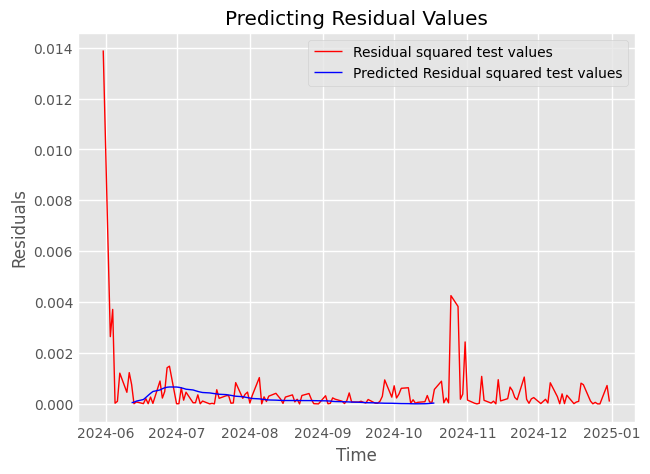

In [105]:
# Visualizing the results for LSTM
plot_predictions(residuals_squared_test,predicted_stock_price_df['Predicted'])

In [106]:
# Evaluating our model
return_rmse(residuals_squared_test[8:101],predicted_stock_price_df['Predicted'])

The root mean squared error is 0.0003218471857598956.


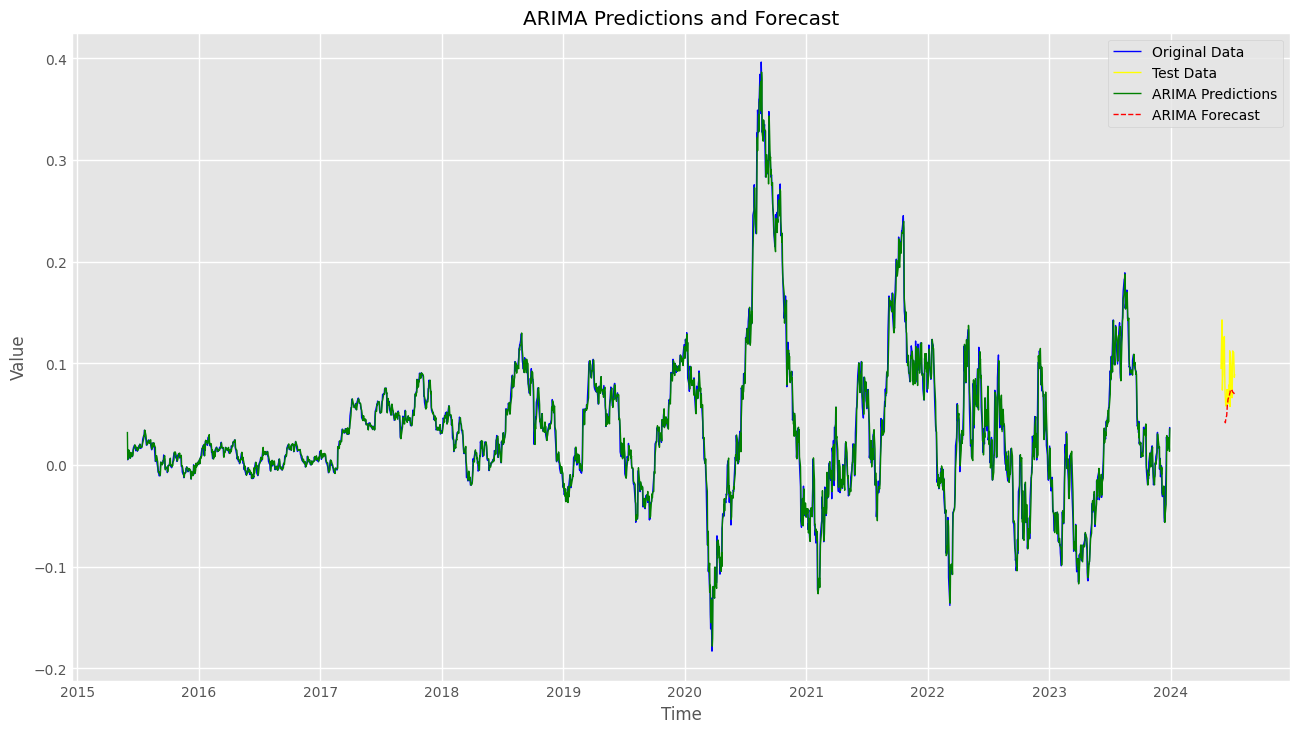

The calculated Root Mean Square Error (RMSE) is: 0.022910033591156932
The calculated Mean Absolute Error (MAE) is: 0.019859021905001887


In [136]:
models = {
    "ARIMA": (arima_pred, predicted_stock_price_df['Summed'])
}

for model_name, (predictions, forecast) in models.items():
    plt.figure(figsize=(14, 8))
    plt.plot(data_diff, label="Original Data", color="blue", linewidth = 1)
    plt.plot(test_diff[:30], label='Test Data', color="yellow", linewidth = 1)
    plt.plot(predictions, label=f"{model_name} Predictions", color="green", linewidth = 1)
    plt.plot(
        forecast[:30],
        label=f"{model_name} Forecast",
        color="red",
        linestyle="dashed",
        linewidth = 1
    )
    plt.title(f"{model_name} Predictions and Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    forecast_aligned, actual_aligned = forecast[:30].align(test_diff[:30], join='inner')
    meanSquaredError = ((forecast_aligned - actual_aligned) ** 2).mean()
    meanAbsError = (abs(forecast_aligned - actual_aligned)).mean()

    # Calculate the RMSE by taking the square root of the MSE
    rmse = np.sqrt(meanSquaredError)
    # Print the RMSE
    print("The calculated Root Mean Square Error (RMSE) is: " + str(rmse))
    print("The calculated Mean Absolute Error (MAE) is: " + str(meanAbsError))

In [135]:
# one can see that the RMSE and MSE are lower in ARIMA-LSTM model than what we got in only ARIMA model.

## Tata Consultancy Services

### Importing the data

In [138]:
import yfinance as yf
df = yf.download('TCS.NS',start="2015-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


### Processing the data

In [139]:
scaler = MinMaxScaler(feature_range=(0,1))
df['Normalized'] = scaler.fit_transform(df['Close'])

In [140]:
training_set = df[:'2023']
test_set = df['2024':]

In [141]:
training_set_scaled = scaler.fit_transform(training_set['Close'])

### Decomposition of data into its components

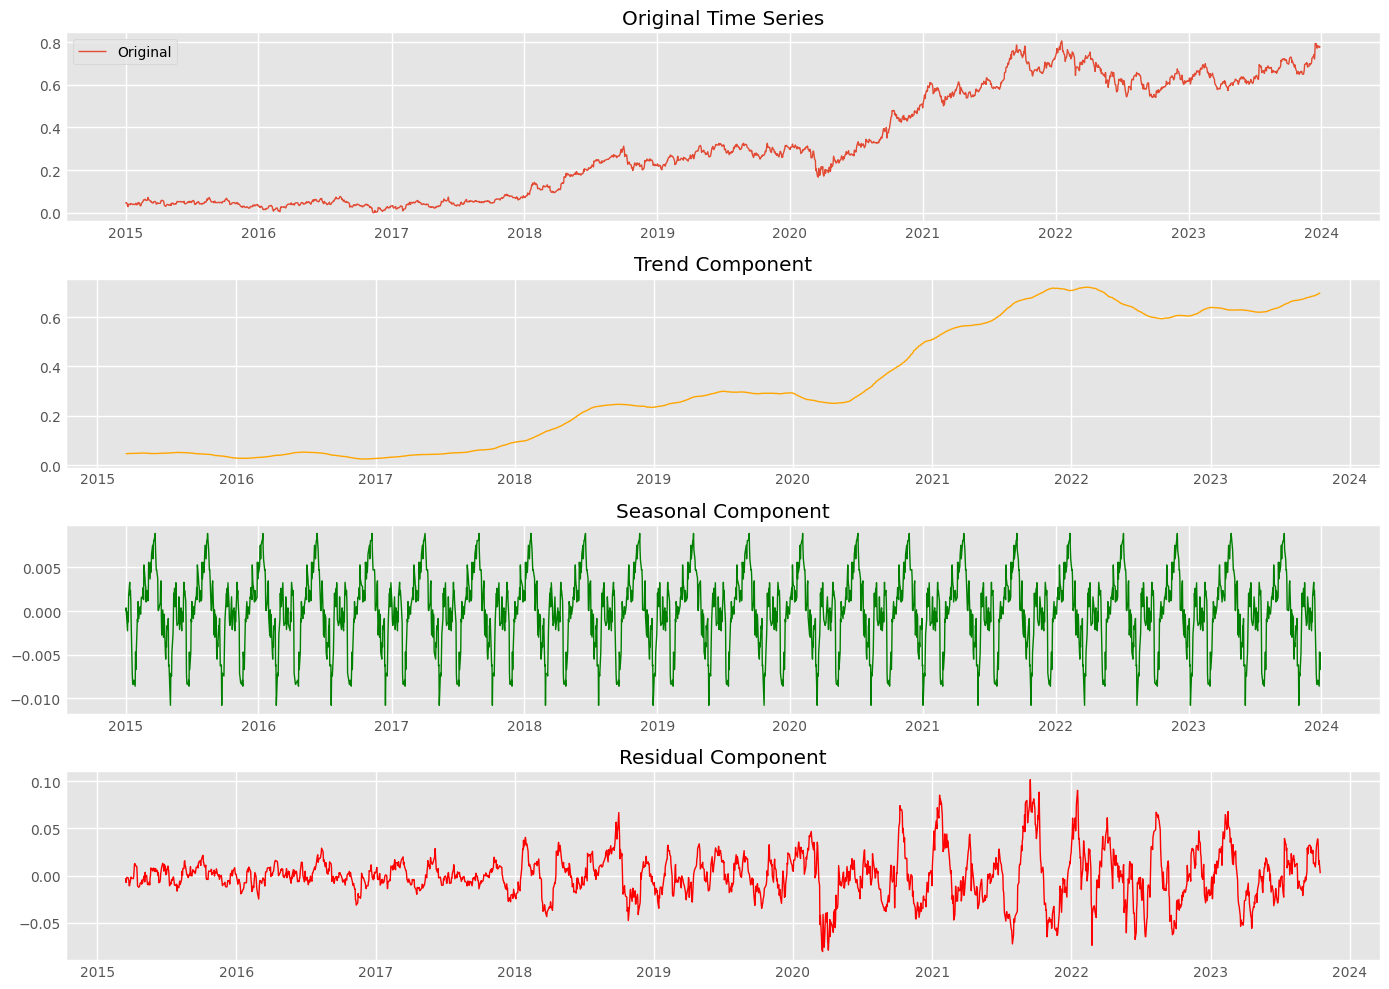

In [142]:
res = seasonal_decompose(training_set['Normalized'], period=100, model="additive") # Here, 100 is obtained by first differencing and then observing peak in ACF plot.

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(training_set['Normalized'], label="Original", linewidth = 1)
plt.title("Original Time Series")
plt.legend()

plt.subplot(412)
plt.plot(res.trend, color='orange', linewidth = 1)
plt.title("Trend Component")

plt.subplot(413)
plt.plot(res.seasonal, color='green', linewidth = 1)
plt.title("Seasonal Component")

plt.subplot(414)
plt.plot(res.resid, color='red', linewidth = 1)
plt.title("Residual Component")

plt.tight_layout()
plt.show()

### Plotting the time series

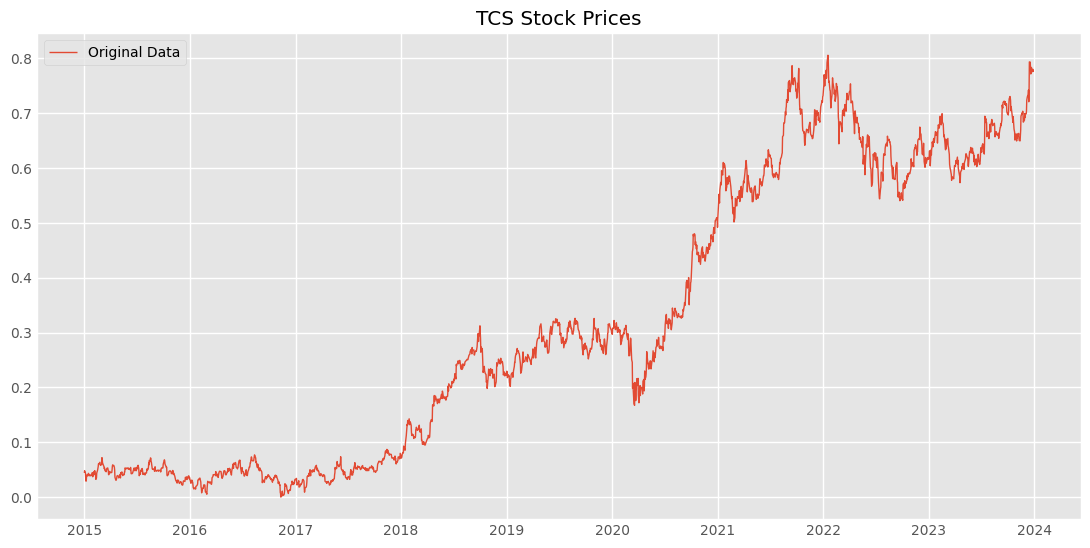

In [144]:
plt.figure(figsize=(12, 6))
plt.plot(training_set['Normalized'], label="Original Data", linewidth = 1)
plt.title("TCS Stock Prices")
plt.legend()
plt.show()

### Checking Stationarity

In [145]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
check_stationarity(training_set['Normalized'])

ADF Statistic: -0.2223581845456998
p-value: 0.9358035761394983
The series is not stationary.


In [198]:
# Differencing the testing data
test_diff = test_set['Normalized'].diff(75).dropna()

In [199]:
# If not stationary, perform differencing
# Differencing the training data
data_diff = training_set['Normalized'].diff(75).dropna()

In [156]:
check_stationarity(data_diff)
check_stationarity(test_diff) # Despite being non-stationary, the test_set is not big enough to perform 100 differencing
# if differencing of train_Set is changed to something to make test_set stationary then log likelihood of arima model
# reduces drastically

ADF Statistic: -4.141958529982158
p-value: 0.0008249030505661133
The series is stationary.
ADF Statistic: -2.7114383572609264
p-value: 0.07207976239968766
The series is not stationary.


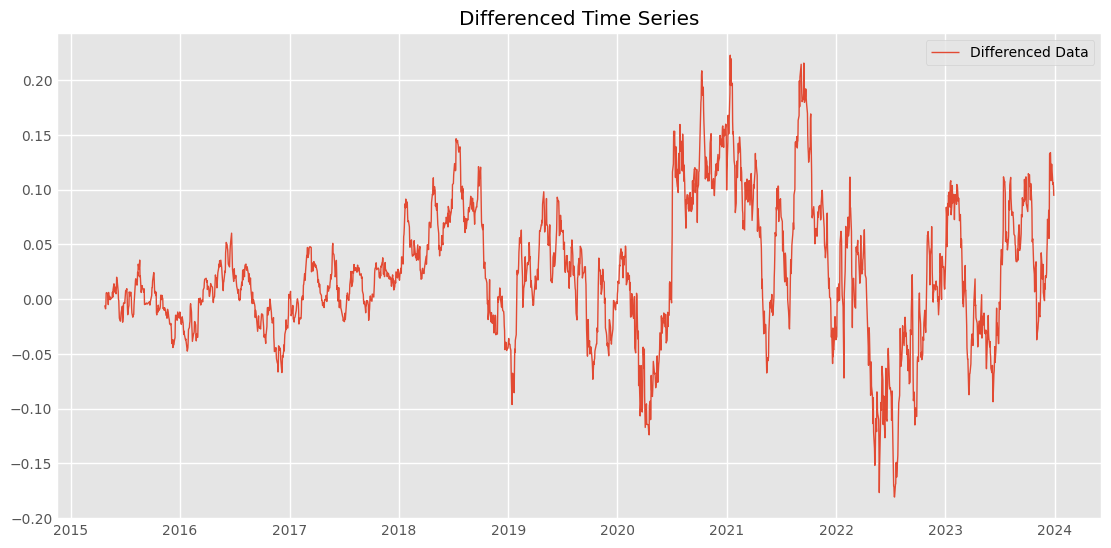

In [157]:
plt.figure(figsize=(12, 6))
plt.plot(data_diff, label="Differenced Data", linewidth = 1)
plt.title("Differenced Time Series")
plt.legend()
plt.show()

### ACF and PACF Plots

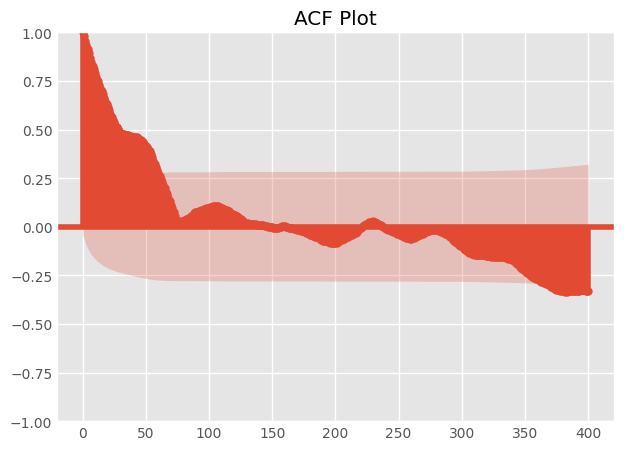

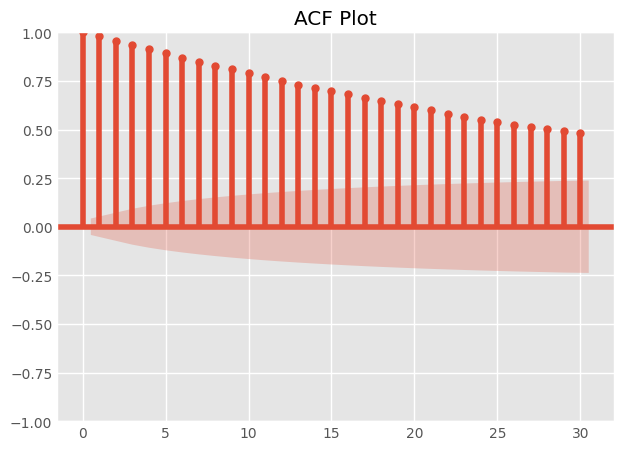

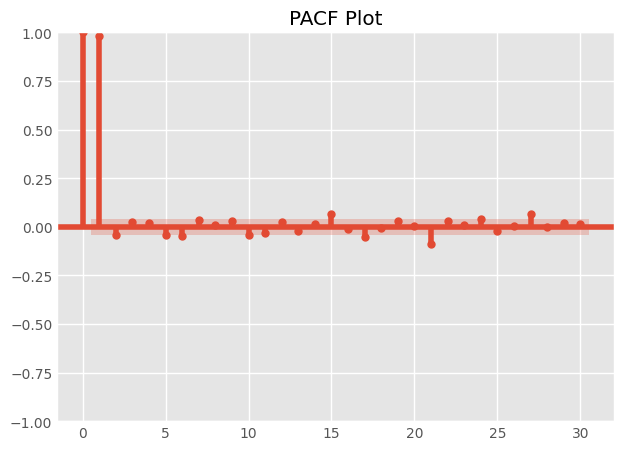

In [158]:
plot_acf(data_diff, lags=400) # from here, i obtained d=100, observe the peak at 100
plt.title("ACF Plot")
plt.show()

plot_acf(data_diff, lags=30)
plt.title("ACF Plot")
plt.show()

plot_pacf(data_diff, lags=30)
plt.title("PACF Plot")
plt.show()

In [159]:
data_diff = data_diff.asfreq('B')
test_diff = test_diff.asfreq('B')
# setting the frequency of data as 'B' meaning business days
# and filling the NaN values thus created
data_diff = data_diff.fillna(method='ffill')
test_diff = test_diff.fillna(method='ffill')

In [160]:
# checking with arima the train_set
# with above pacf and acf values
arima_model = ARIMA(data_diff, order=(1,0,30))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Normalized   No. Observations:                 2266
Model:                ARIMA(1, 0, 30)   Log Likelihood                6777.038
Date:                Fri, 31 Jan 2025   AIC                         -13488.075
Time:                        14:37:23   BIC                         -13299.125
Sample:                    04-24-2015   HQIC                        -13419.134
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0236      0.014      1.691      0.091      -0.004       0.051
ar.L1          0.9834      0.006    152.093      0.000       0.971       0.996
ma.L1          0.0321      0.018      1.827      0.068      -0.002       0.067
ma.L2         -0.0176      0.018     -0.984      0.325      -0.053       0.017
ma.L3         -0.0348      0.018     -1.933      0.053      -0.070       0.000
ma.L4          0.0147      0.019      0.758      0.449      -0.023       0.053
ma.L5          0.0394      0.019      2.120      0.034       0.003       0.076
ma.L6         -0.0371      0.018     -2.021      0.043      -0.073      -0.001
ma.L7         -0.0036      0.018     -0.195      0.846      -0.039       0.032
ma.L8         -0.0471      0.019     -2.491      0.013      -0.084      -0.010
ma.L9          0.0459      0.018      2.578      0.010       0.011       0.081
ma.L10         0.0173      0.017      1.016      0.309      -0.016       0.051
ma.L11         0.0002      0.019      0.010      0.992      -0.038       0.038
ma.L12         0.0317      0.018      1.729      0.084      -0.004       0.068
ma.L13        -0.0224      0.020     -1.131      0.258      -0.061       0.016
ma.L14        -0.0565      0.018     -3.103      0.002      -0.092      -0.021
ma.L15        -0.0287      0.018     -1.590      0.112      -0.064       0.007
ma.L16         0.0198      0.018      1.086      0.277      -0.016       0.056
ma.L17         0.0532      0.017      3.152      0.002       0.020       0.086
ma.L18        -0.0172      0.019     -0.898      0.369      -0.055       0.020
ma.L19        -0.0160      0.018     -0.866      0.386      -0.052       0.020
ma.L20         0.0572      0.019      3.015      0.003       0.020       0.094
ma.L21        -0.0088      0.019     -0.454      0.650      -0.047       0.029
ma.L22         0.0368      0.019      1.971      0.049       0.000       0.073
ma.L23        -0.0289      0.018     -1.564      0.118      -0.065       0.007
ma.L24        -0.0149      0.020     -0.747      0.455      -0.054       0.024
ma.L25         0.0151      0.019      0.795      0.426      -0.022       0.052
ma.L26        -0.0245      0.019     -1.278      0.201      -0.062       0.013
ma.L27        -0.0222      0.019     -1.185      0.236      -0.059       0.015
ma.L28        -0.0368      0.019     -1.934      0.053      -0.074       0.001
ma.L29        -0.0646      0.018     -3.668      0.000      -0.099      -0.030
ma.L30         0.0070      0.018      0.384      0.701      -0.029       0.043
sigma2         0.0001   2.99e-06     49.390      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               848.35
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.58   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:       

In [161]:
residuals_train = arima_fit.resid # saving the arima model residuals for the train set

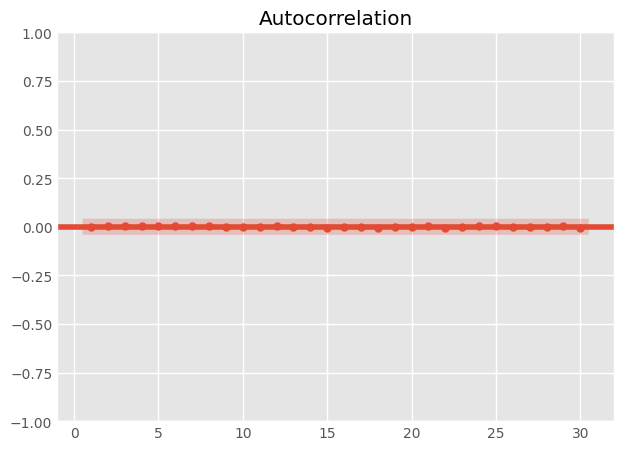

In [162]:
# analyzing residuals of arima
plot_acf(arima_fit.resid, zero=False,lags=30)
plt.show()

In [163]:
# predicting arima values
arima_pred = arima_fit.predict(start=data_diff.index[0], end=data_diff.index[-1], typ='levels')
arima_forecast = arima_fit.forecast(steps=153)
arima_forecast = pd.Series(arima_forecast.values, index=test_diff.index)

In [200]:
# arima model to get the residuals of the train_Set which will be required further
arima_model = ARIMA(test_diff, order=(1,0,30))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Normalized   No. Observations:                  171
Model:                ARIMA(1, 0, 30)   Log Likelihood                 430.243
Date:                Fri, 31 Jan 2025   AIC                           -794.487
Time:                        15:52:23   BIC                           -690.812
Sample:                             0   HQIC                          -752.420
                                - 171                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0465      0.153      0.304      0.761      -0.253       0.346
ar.L1          0.9783      0.030     32.372      0.000       0.919       1.037
ma.L1          0.0836      0.097      0.862      0.389      -0.107       0.274
ma.L2          0.0162      0.105      0.154      0.877      -0.190       0.223
ma.L3          0.1256      0.108      1.165      0.244      -0.086       0.337
ma.L4         -0.0424      0.102     -0.417      0.677      -0.242       0.157
ma.L5         -0.0381      0.126     -0.302      0.763      -0.286       0.209
ma.L6         -0.0562      0.103     -0.545      0.586      -0.259       0.146
ma.L7          0.1116      0.120      0.930      0.352      -0.124       0.347
ma.L8          0.0489      0.094      0.519      0.604      -0.136       0.234
ma.L9         -0.1010      0.108     -0.936      0.349      -0.313       0.111
ma.L10         0.2096      0.112      1.874      0.061      -0.010       0.429
ma.L11         0.0903      0.114      0.791      0.429      -0.134       0.314
ma.L12        -0.0246      0.116     -0.213      0.832      -0.251       0.202
ma.L13         0.1123      0.102      1.100      0.271      -0.088       0.312
ma.L14         0.0623      0.096      0.646      0.518      -0.127       0.251
ma.L15        -0.0151      0.102     -0.148      0.882      -0.215       0.184
ma.L16        -0.1258      0.094     -1.340      0.180      -0.310       0.058
ma.L17         0.1156      0.104      1.116      0.264      -0.087       0.319
ma.L18         0.0817      0.125      0.655      0.512      -0.163       0.326
ma.L19         0.0753      0.121      0.623      0.533      -0.162       0.312
ma.L20         0.0334      0.109      0.306      0.760      -0.180       0.247
ma.L21        -0.0637      0.107     -0.596      0.551      -0.273       0.146
ma.L22         0.0670      0.098      0.684      0.494      -0.125       0.259
ma.L23        -0.1076      0.105     -1.020      0.308      -0.314       0.099
ma.L24        -0.0010      0.100     -0.010      0.992      -0.196       0.194
ma.L25         0.1182      0.117      1.013      0.311      -0.110       0.347
ma.L26        -0.0908      0.102     -0.886      0.375      -0.291       0.110
ma.L27         0.2349      0.111      2.123      0.034       0.018       0.452
ma.L28         0.1591      0.134      1.185      0.236      -0.104       0.422
ma.L29         0.0110      0.119      0.092      0.926      -0.223       0.245
ma.L30        -0.0779      0.123     -0.633      0.526      -0.319       0.163
sigma2         0.0004    4.3e-05      8.425      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                43.07
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.67
Prob(H) (two-sided):                  0.18   Kurtosis:       

In [201]:
residuals_test = arima_fit.resid #saving arima residuals for the test_set

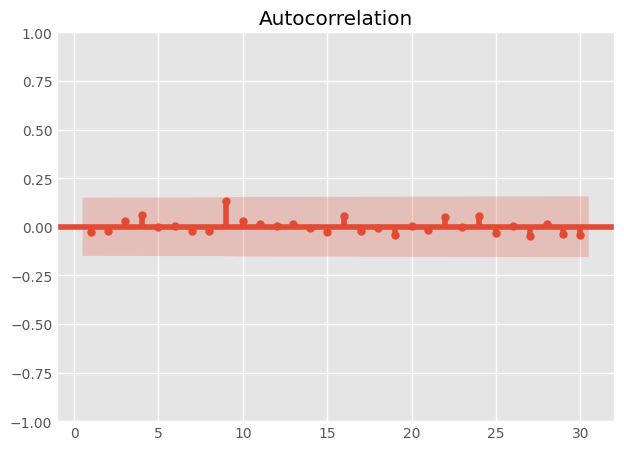

In [202]:
# analyzing residuals of arima
plot_acf(arima_fit.resid, zero=False,lags=30)
plt.show()

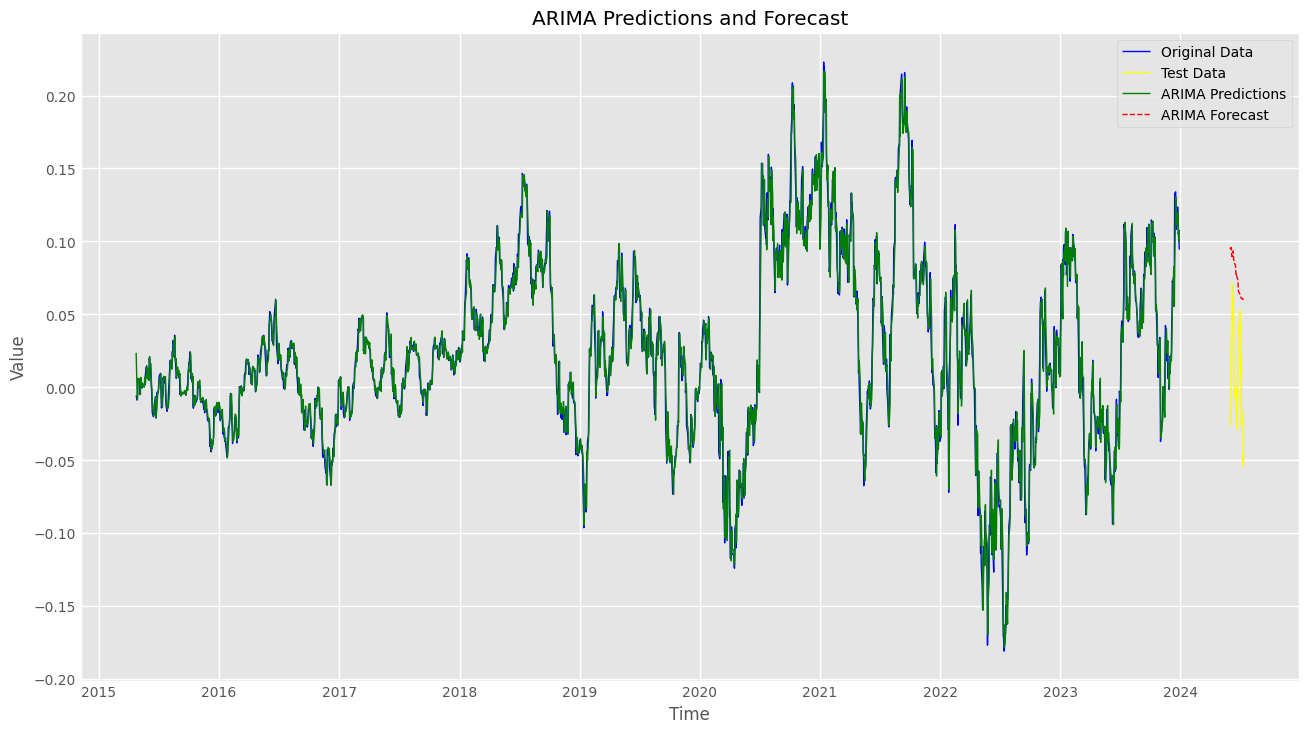

The calculated Root Mean Square Error (RMSE) is: 0.07399953806897652
The calculated Mean Absolute Error (MAE) is: 0.06696680677338795


In [167]:
models = {
    "ARIMA": (arima_pred, arima_forecast)
}

for model_name, (predictions, forecast) in models.items():
    plt.figure(figsize=(14, 8))
    plt.plot(data_diff, label="Original Data", color="blue", linewidth = 1)
    plt.plot(test_diff[:30], label='Test Data', color="yellow", linewidth = 1) #first 30
    plt.plot(predictions, label=f"{model_name} Predictions", color="green", linewidth = 1)
    plt.plot(
        forecast[:30], #just using first 30 as q value is 30 - meaning only 30 days can be predicted accurately
        # 'https://stackoverflow.com/questions/72030718/getting-straight-line-while-creating-arima-model'
        label=f"{model_name} Forecast",
        color="red",
        linestyle="dashed",
        linewidth = 1
    )
    plt.title(f"{model_name} Predictions and Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    forecast_aligned, actual_aligned = forecast[:30].align(test_diff[:30], join='inner')
    meanSquaredError = ((forecast_aligned - actual_aligned) ** 2).mean()
    meanAbsError = (abs(forecast_aligned - actual_aligned)).mean()

    # Calculate the RMSE by taking the square root of the MSE
    rmse = np.sqrt(meanSquaredError)
    # Print the RMSE
    print("The calculated Root Mean Square Error (RMSE) is: " + str(rmse))
    print("The calculated Mean Absolute Error (MAE) is: " + str(meanAbsError))

### Starting with the LSTM part of the model

In [168]:
# Square the residuals of train_set
residuals_squared_train = residuals_train**2

# Normalizing using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

residuals_squared_train_df = pd.DataFrame(residuals_squared_train, columns=["squared_residuals"])

residuals_scaled_train = scaler.fit_transform(residuals_squared_train_df)

In [203]:
# Square the residuals of test_Set
residuals_squared_test = residuals_test**2

# Normalizing using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

residuals_squared_test_df = pd.DataFrame(residuals_squared_test, columns=["squared_residuals"])

residuals_scaled_test = scaler.fit_transform(residuals_squared_test_df)

In [170]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2240):
    X_train.append(residuals_scaled_train[i-60:i])
    y_train.append(residuals_scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [171]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [172]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - loss: 0.0036
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.0038
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0037
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0033
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - loss: 0.0030
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - loss: 0.0038
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.0026
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0031
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.0035
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - loss: 0.0036
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.0035
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0037
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.0034
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.0036
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/

In [204]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
dataset_total = pd.concat((residuals_squared_train,residuals_squared_test),axis=0)
inputs = dataset_total[len(dataset_total)-len(residuals_squared_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [205]:
X_test = []
for i in range(60,153):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [206]:
predicted_stock_price_df = pd.DataFrame(predicted_stock_price, columns=['Predicted'], index=residuals_squared_test.index[8:101]) # range is taken to minimize rmse

In [225]:
predicted_stock_price_df['Summed'] = predicted_stock_price_df['Predicted'][17:]**0.5 + arima_forecast[:-74] #adding the residuals and arima data thus creating the hybrid

In [177]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Residual squared test values', linewidth=1)
    plt.plot(predicted, color='blue',label='Predicted Residual squared test values', linewidth=1)
    plt.title('Predicting Residual Values')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

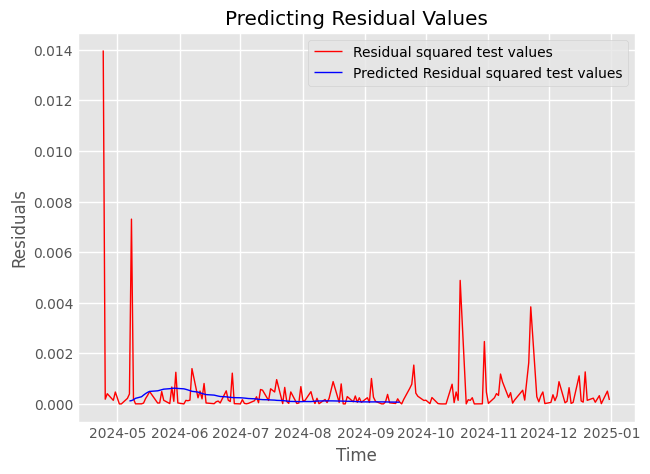

In [208]:
# Visualizing the results for LSTM
plot_predictions(residuals_squared_test,predicted_stock_price_df['Predicted'])

In [209]:
# Evaluating our model
return_rmse(residuals_squared_test[8:101],predicted_stock_price_df['Predicted'])

The root mean squared error is 0.0008165225565731791.


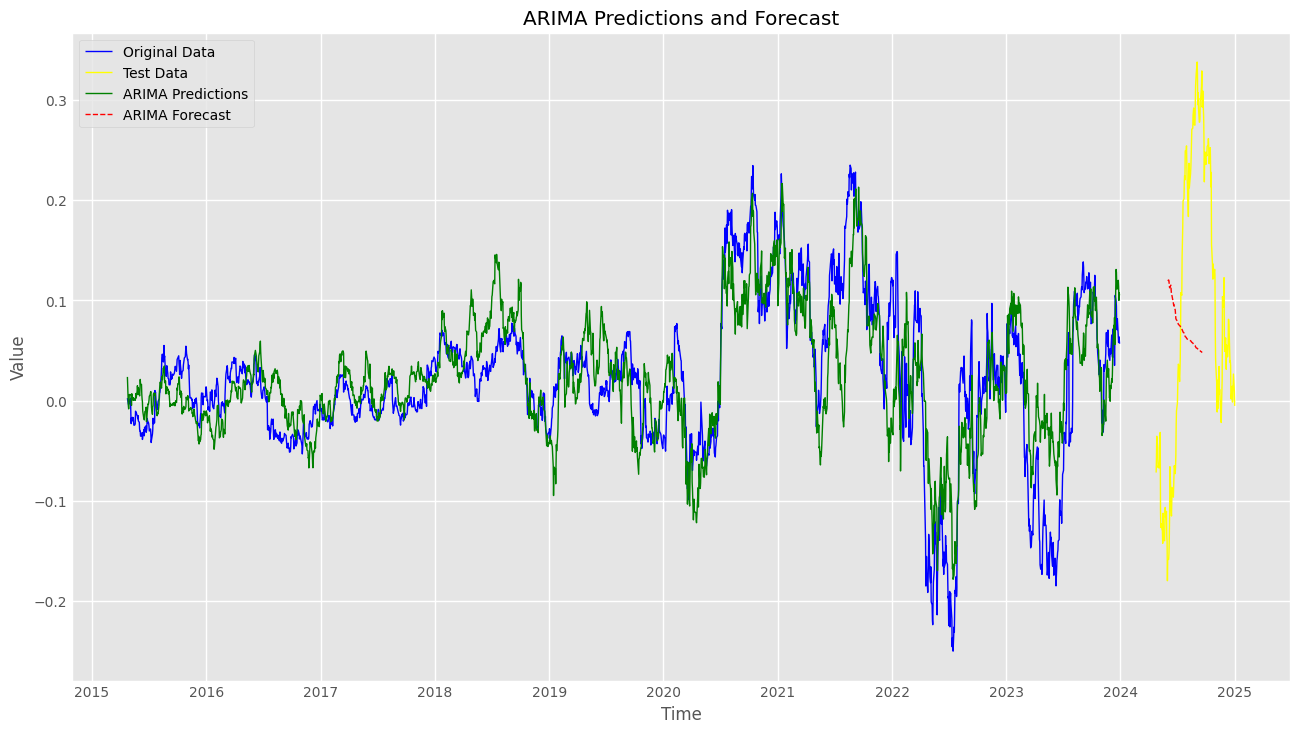

The calculated Root Mean Square Error (RMSE) is: 0.26205629859608964
The calculated Mean Absolute Error (MAE) is: 0.26129248492471263


In [228]:
models = {
    "ARIMA": (arima_pred, predicted_stock_price_df['Summed'].dropna())
}

for model_name, (predictions, forecast) in models.items():
    plt.figure(figsize=(14, 8))
    plt.plot(data_diff, label="Original Data", color="blue", linewidth = 1)
    plt.plot(test_diff, label='Test Data', color="yellow", linewidth = 1)
    plt.plot(predictions, label=f"{model_name} Predictions", color="green", linewidth = 1)
    plt.plot(
        forecast,
        label=f"{model_name} Forecast",
        color="red",
        linestyle="dashed",
        linewidth = 1
    )
    plt.title(f"{model_name} Predictions and Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    forecast_aligned, actual_aligned = forecast[:30].align(test_diff[:30], join='inner')
    meanSquaredError = ((forecast_aligned - actual_aligned) ** 2).mean()
    meanAbsError = (abs(forecast_aligned - actual_aligned)).mean()

    # Calculate the RMSE by taking the square root of the MSE
    rmse = np.sqrt(meanSquaredError)
    # Print the RMSE
    print("The calculated Root Mean Square Error (RMSE) is: " + str(rmse))
    print("The calculated Mean Absolute Error (MAE) is: " + str(meanAbsError))

In [ ]:
# one can see that the RMSE and MSE are lower in ARIMA-LSTM model than what we got in only ARIMA model.

## Infosys Limited

### Importing the data

In [185]:
import yfinance as yf
df = yf.download('INFY.NS',start="2015-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


### Processing the data

In [186]:
scaler = MinMaxScaler(feature_range=(0,1))
df['Normalized'] = scaler.fit_transform(df['Close'])

In [187]:
training_set = df[:'2023']
test_set = df['2024':]

In [188]:
training_set_scaled = scaler.fit_transform(training_set['Close'])

### Decomposition of data into its components

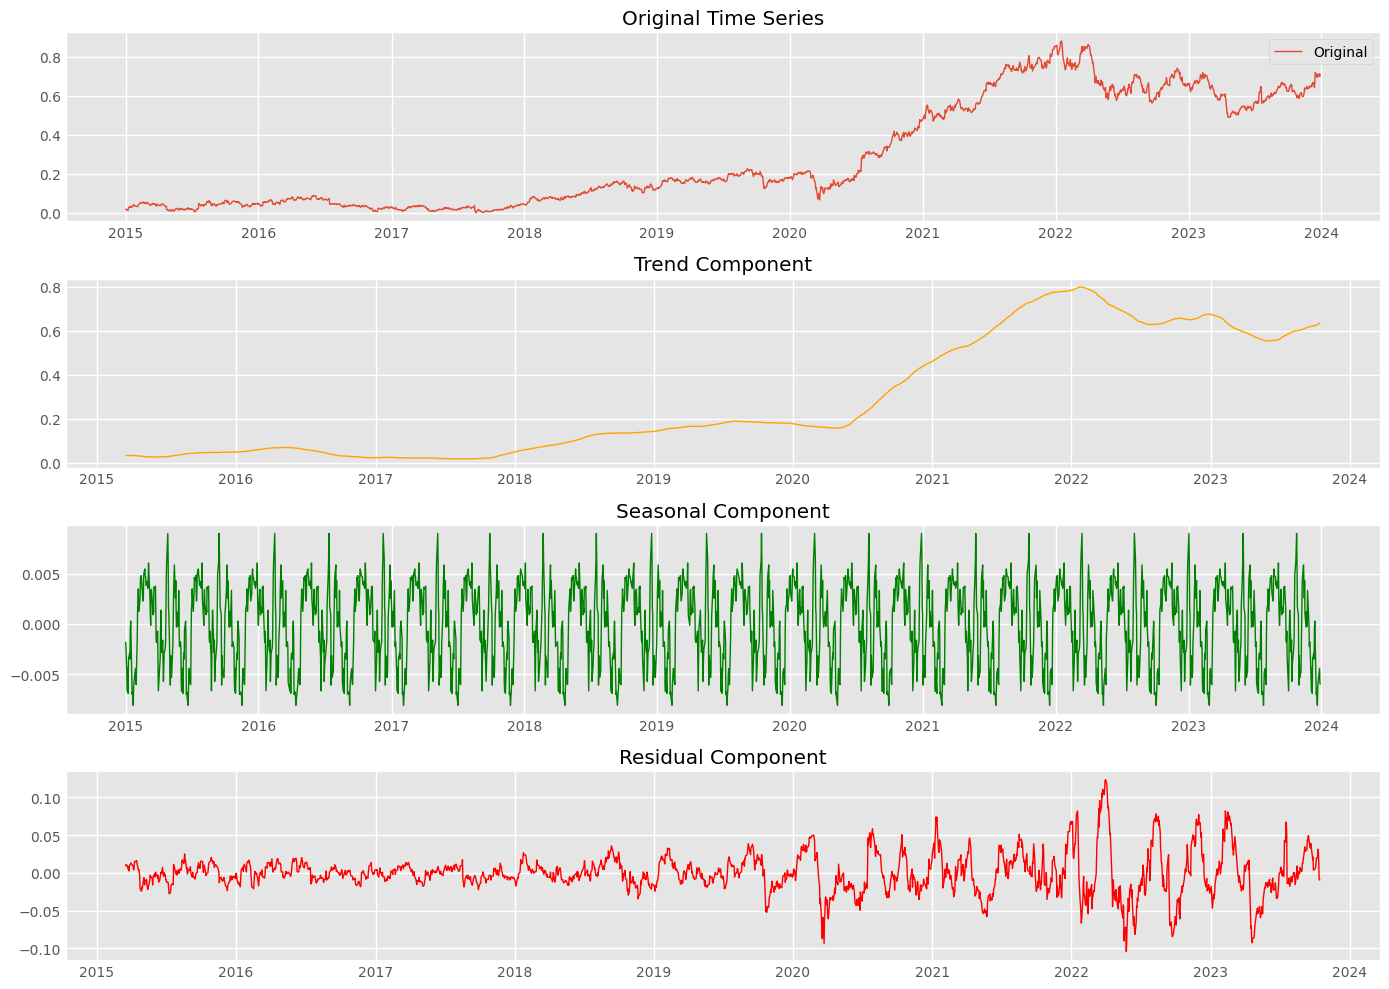

In [189]:
res = seasonal_decompose(training_set['Normalized'], period=100, model="additive") # Here, 100 is obtained by first differencing and then observing peak in ACF plot.

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(training_set['Normalized'], label="Original", linewidth = 1)
plt.title("Original Time Series")
plt.legend()

plt.subplot(412)
plt.plot(res.trend, color='orange', linewidth = 1)
plt.title("Trend Component")

plt.subplot(413)
plt.plot(res.seasonal, color='green', linewidth = 1)
plt.title("Seasonal Component")

plt.subplot(414)
plt.plot(res.resid, color='red', linewidth = 1)
plt.title("Residual Component")

plt.tight_layout()
plt.show()

### Plotting the time series

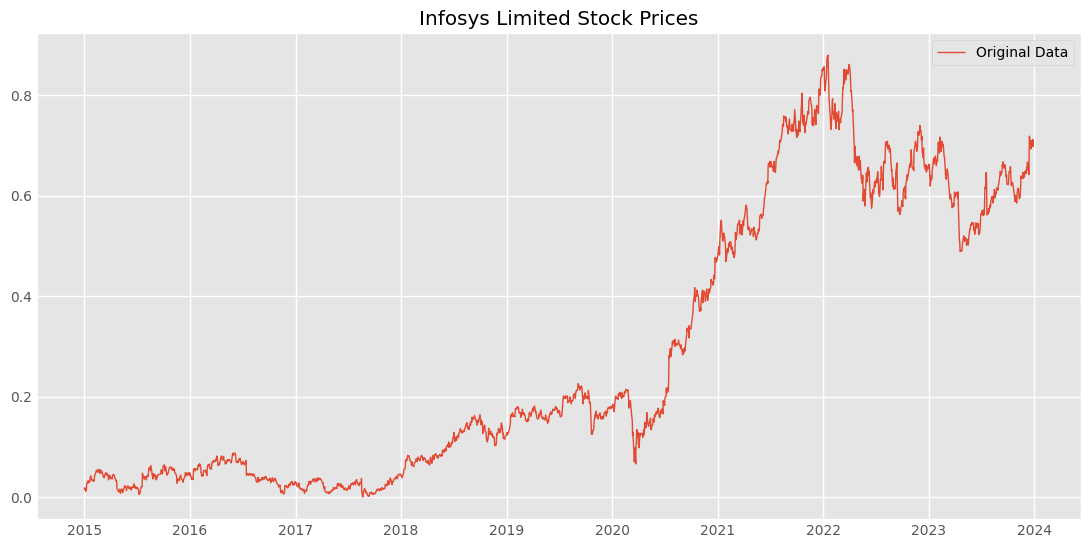

In [229]:
plt.figure(figsize=(12, 6))
plt.plot(training_set['Normalized'], label="Original Data", linewidth = 1)
plt.title("Infosys Limited Stock Prices")
plt.legend()
plt.show()

### Checking Stationarity

In [191]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
check_stationarity(training_set['Normalized'])

ADF Statistic: -0.28003636529254605
p-value: 0.9282845760834526
The series is not stationary.


In [230]:
# Differencing the testing data
test_diff = test_set['Normalized'].diff(75).dropna()

In [231]:
# If not stationary, perform differencing
# Differencing the training data
data_diff = training_set['Normalized'].diff(75).dropna()

In [232]:
check_stationarity(data_diff)
check_stationarity(test_diff) # Despite being non-stationary, the test_set is not big enough to perform 100 differencing
# if differencing of train_Set is changed to something to make test_set stationary then log likelihood of arima model
# reduces drastically

ADF Statistic: -3.949427294359833
p-value: 0.0016997488342221205
The series is stationary.
ADF Statistic: -1.1342195390640386
p-value: 0.7012344780629307
The series is not stationary.


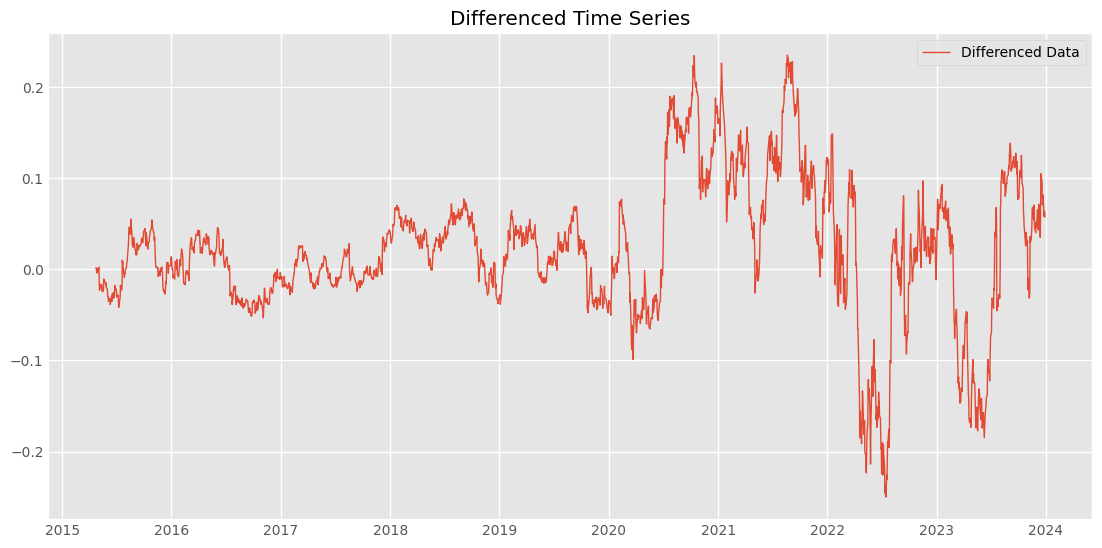

In [233]:
plt.figure(figsize=(12, 6))
plt.plot(data_diff, label="Differenced Data", linewidth = 1)
plt.title("Differenced Time Series")
plt.legend()
plt.show()

### ACF and PACF Plots

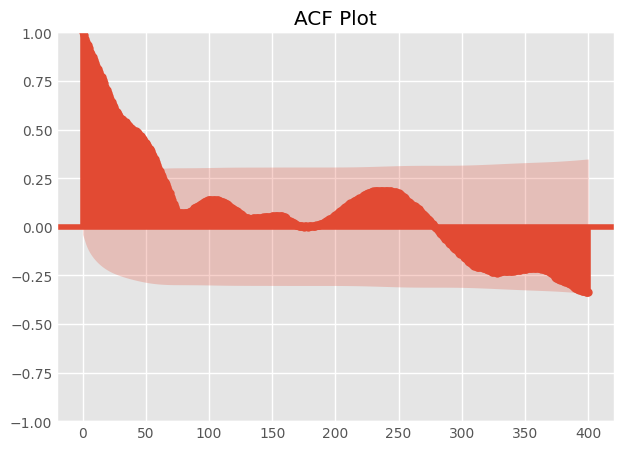

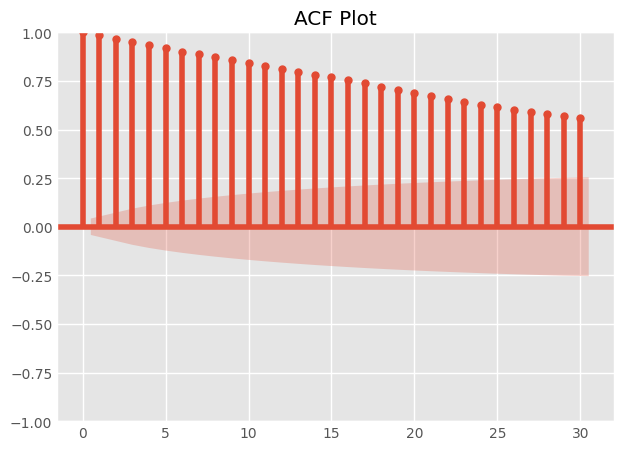

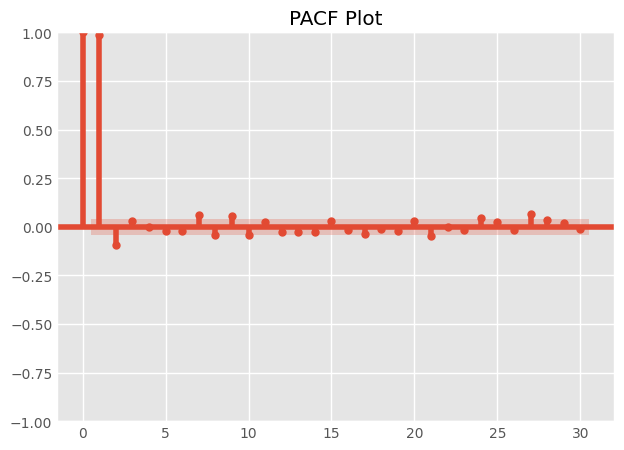

In [234]:
plot_acf(data_diff, lags=400) # from here, i obtained d=100, observe the peak at 100
plt.title("ACF Plot")
plt.show()

plot_acf(data_diff, lags=30)
plt.title("ACF Plot")
plt.show()

plot_pacf(data_diff, lags=30)
plt.title("PACF Plot")
plt.show()

In [235]:
data_diff = data_diff.asfreq('B')
test_diff = test_diff.asfreq('B')
# setting the frequency of data as 'B' meaning business days
# and filling the NaN values thus created
data_diff = data_diff.fillna(method='ffill')
test_diff = test_diff.fillna(method='ffill')

In [236]:
# checking with arima the train_set
# with above pacf and acf values
arima_model = ARIMA(data_diff, order=(1,0,30))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Normalized   No. Observations:                 2266
Model:                ARIMA(1, 0, 30)   Log Likelihood                6708.324
Date:                Fri, 31 Jan 2025   AIC                         -13350.649
Time:                        16:07:17   BIC                         -13161.699
Sample:                    04-24-2015   HQIC                        -13281.708
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0216      0.018      1.202      0.229      -0.014       0.057
ar.L1          0.9842      0.005    204.432      0.000       0.975       0.994
ma.L1          0.0775      0.016      4.874      0.000       0.046       0.109
ma.L2         -0.0081      0.017     -0.468      0.640      -0.042       0.026
ma.L3         -0.0282      0.016     -1.728      0.084      -0.060       0.004
ma.L4          0.0110      0.016      0.670      0.503      -0.021       0.043
ma.L5          0.0321      0.016      2.043      0.041       0.001       0.063
ma.L6         -0.0458      0.018     -2.535      0.011      -0.081      -0.010
ma.L7         -0.0096      0.018     -0.538      0.590      -0.044       0.025
ma.L8         -0.0466      0.015     -3.125      0.002      -0.076      -0.017
ma.L9          0.0605      0.018      3.448      0.001       0.026       0.095
ma.L10         0.0447      0.016      2.779      0.005       0.013       0.076
ma.L11        -0.0120      0.018     -0.667      0.505      -0.047       0.023
ma.L12         0.0290      0.019      1.553      0.120      -0.008       0.066
ma.L13         0.0093      0.017      0.551      0.581      -0.024       0.042
ma.L14        -0.0027      0.016     -0.164      0.870      -0.035       0.029
ma.L15        -0.0031      0.017     -0.185      0.853      -0.036       0.030
ma.L16         0.0152      0.018      0.852      0.394      -0.020       0.050
ma.L17         0.0219      0.016      1.333      0.183      -0.010       0.054
ma.L18         0.0238      0.018      1.350      0.177      -0.011       0.058
ma.L19         0.0046      0.017      0.266      0.790      -0.029       0.038
ma.L20         0.0019      0.019      0.105      0.916      -0.034       0.038
ma.L21         0.0131      0.017      0.757      0.449      -0.021       0.047
ma.L22         0.0137      0.018      0.767      0.443      -0.021       0.049
ma.L23         0.0097      0.017      0.558      0.577      -0.024       0.044
ma.L24        -0.0271      0.019     -1.453      0.146      -0.064       0.009
ma.L25         0.0026      0.016      0.159      0.873      -0.030       0.035
ma.L26        -0.0126      0.017     -0.718      0.473      -0.047       0.022
ma.L27        -0.0268      0.018     -1.504      0.133      -0.062       0.008
ma.L28        -0.0405      0.017     -2.384      0.017      -0.074      -0.007
ma.L29        -0.0599      0.017     -3.522      0.000      -0.093      -0.027
ma.L30        -0.0183      0.017     -1.096      0.273      -0.051       0.014
sigma2         0.0002   2.78e-06     56.406      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2749.62
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              10.30   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:       

In [237]:
residuals_train = arima_fit.resid # saving the arima model residuals for the train set

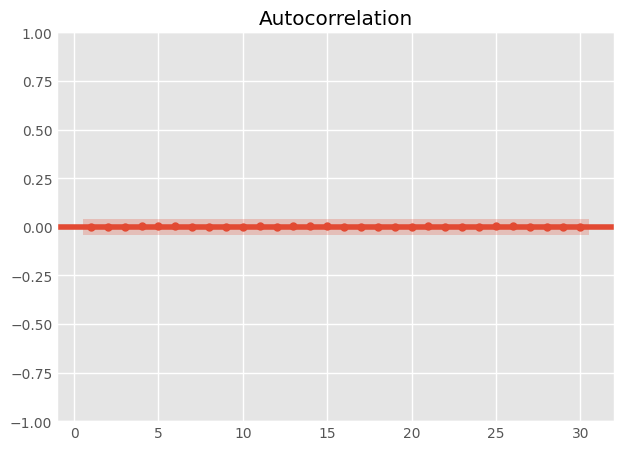

In [238]:
# analyzing residuals of arima
plot_acf(arima_fit.resid, zero=False,lags=30)
plt.show()

In [240]:
# predicting arima values
arima_pred = arima_fit.predict(start=data_diff.index[0], end=data_diff.index[-1], typ='levels')
arima_forecast = arima_fit.forecast(steps=180)
arima_forecast = pd.Series(arima_forecast.values, index=test_diff.index)

In [241]:
# arima model to get the residuals of the train_Set which will be required further
arima_model = ARIMA(test_diff, order=(1,0,30))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Normalized   No. Observations:                  180
Model:                ARIMA(1, 0, 30)   Log Likelihood                 462.862
Date:                Fri, 31 Jan 2025   AIC                           -859.723
Time:                        16:08:34   BIC                           -754.356
Sample:                    04-24-2024   HQIC                          -817.001
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.345      0.055      0.956      -0.658       0.696
ar.L1          0.9893      0.022     44.902      0.000       0.946       1.032
ma.L1          0.0799      0.096      0.828      0.408      -0.109       0.269
ma.L2          0.0920      0.096      0.962      0.336      -0.095       0.279
ma.L3          0.1110      0.120      0.925      0.355      -0.124       0.346
ma.L4         -0.1110      0.109     -1.014      0.311      -0.326       0.104
ma.L5         -0.0519      0.092     -0.565      0.572      -0.232       0.128
ma.L6         -0.0767      0.088     -0.870      0.384      -0.250       0.096
ma.L7          0.0838      0.096      0.873      0.383      -0.104       0.272
ma.L8         -0.0077      0.102     -0.075      0.940      -0.207       0.192
ma.L9          0.0728      0.101      0.718      0.473      -0.126       0.272
ma.L10         0.1383      0.105      1.316      0.188      -0.068       0.344
ma.L11         0.0634      0.099      0.640      0.522      -0.131       0.258
ma.L12         0.2362      0.106      2.222      0.026       0.028       0.444
ma.L13         0.0143      0.101      0.142      0.887      -0.184       0.212
ma.L14        -0.0212      0.100     -0.212      0.832      -0.217       0.175
ma.L15         0.0844      0.097      0.874      0.382      -0.105       0.274
ma.L16        -0.1608      0.094     -1.713      0.087      -0.345       0.023
ma.L17        -0.1337      0.094     -1.424      0.154      -0.318       0.050
ma.L18         0.1534      0.111      1.376      0.169      -0.065       0.372
ma.L19         0.1899      0.113      1.674      0.094      -0.032       0.412
ma.L20        -0.1227      0.118     -1.038      0.299      -0.354       0.109
ma.L21         0.1032      0.112      0.922      0.357      -0.116       0.323
ma.L22         0.0541      0.111      0.487      0.626      -0.164       0.272
ma.L23         0.0750      0.113      0.664      0.507      -0.147       0.297
ma.L24        -0.1156      0.125     -0.922      0.357      -0.361       0.130
ma.L25        -0.0393      0.106     -0.370      0.711      -0.248       0.169
ma.L26        -0.0471      0.133     -0.354      0.723      -0.308       0.214
ma.L27         0.0234      0.099      0.237      0.813      -0.170       0.216
ma.L28        -0.0639      0.123     -0.518      0.604      -0.306       0.178
ma.L29         0.2445      0.136      1.797      0.072      -0.022       0.511
ma.L30         0.1553      0.105      1.486      0.137      -0.050       0.360
sigma2         0.0003   3.48e-05      9.065      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                49.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.70
Prob(H) (two-sided):                  0.68   Kurtosis:       

In [242]:
residuals_test = arima_fit.resid #saving arima residuals for the test_set

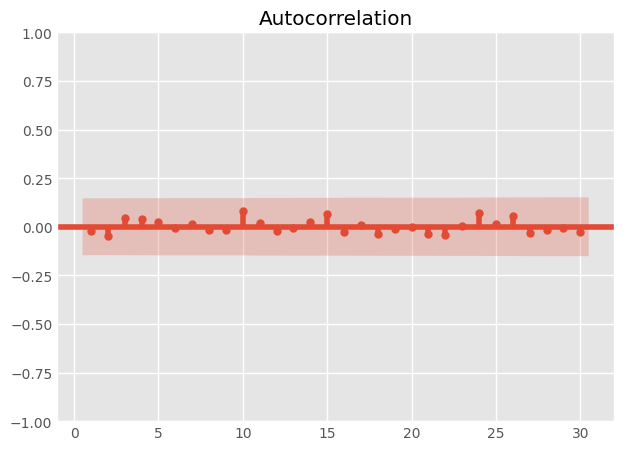

In [243]:
# analyzing residuals of arima
plot_acf(arima_fit.resid, zero=False,lags=30)
plt.show()

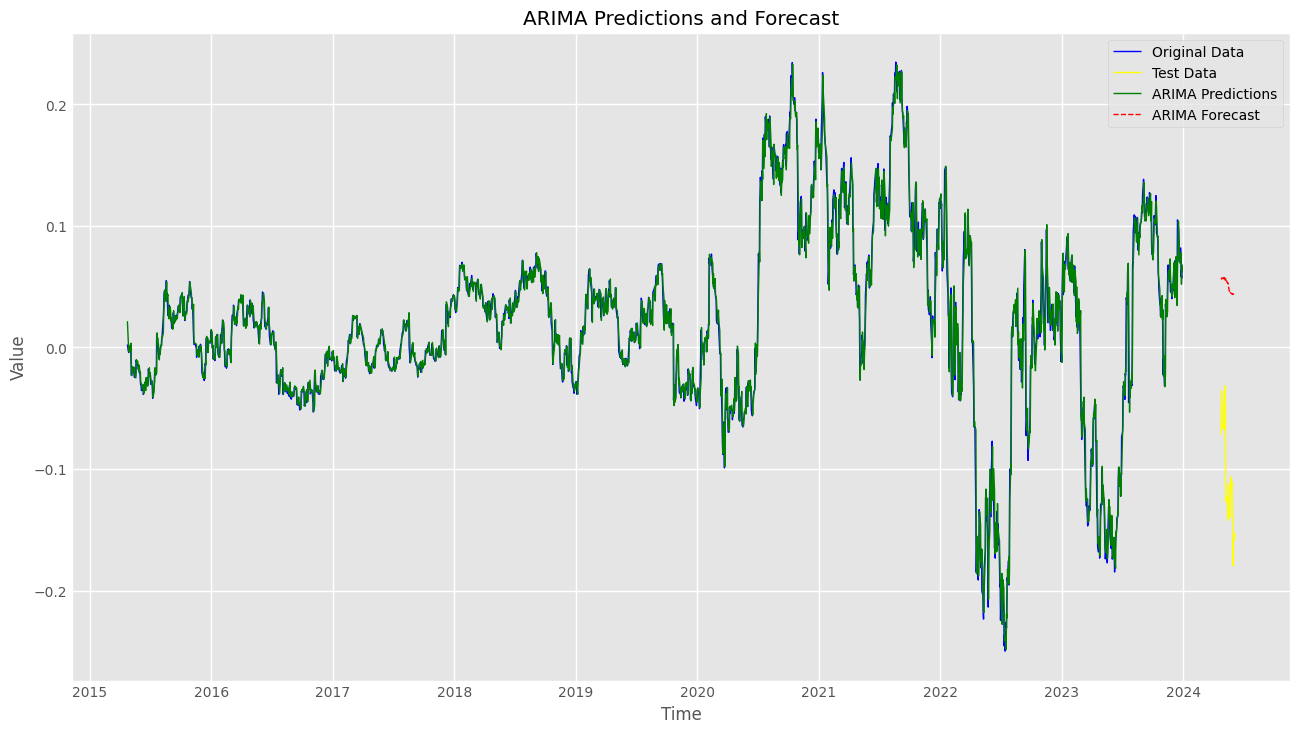

The calculated Root Mean Square Error (RMSE) is: 0.16253426930848155
The calculated Mean Absolute Error (MAE) is: 0.15850345276718644


In [244]:
models = {
    "ARIMA": (arima_pred, arima_forecast)
}

for model_name, (predictions, forecast) in models.items():
    plt.figure(figsize=(14, 8))
    plt.plot(data_diff, label="Original Data", color="blue", linewidth = 1)
    plt.plot(test_diff[:30], label='Test Data', color="yellow", linewidth = 1) #first 30
    plt.plot(predictions, label=f"{model_name} Predictions", color="green", linewidth = 1)
    plt.plot(
        forecast[:30], #just using first 30 as q value is 30 - meaning only 30 days can be predicted accurately
        # 'https://stackoverflow.com/questions/72030718/getting-straight-line-while-creating-arima-model'
        label=f"{model_name} Forecast",
        color="red",
        linestyle="dashed",
        linewidth = 1
    )
    plt.title(f"{model_name} Predictions and Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    forecast_aligned, actual_aligned = forecast[:30].align(test_diff[:30], join='inner')
    meanSquaredError = ((forecast_aligned - actual_aligned) ** 2).mean()
    meanAbsError = (abs(forecast_aligned - actual_aligned)).mean()

    # Calculate the RMSE by taking the square root of the MSE
    rmse = np.sqrt(meanSquaredError)
    # Print the RMSE
    print("The calculated Root Mean Square Error (RMSE) is: " + str(rmse))
    print("The calculated Mean Absolute Error (MAE) is: " + str(meanAbsError))

### Starting with the LSTM part of the model

In [245]:
# Square the residuals of train_set
residuals_squared_train = residuals_train**2

# Normalizing using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

residuals_squared_train_df = pd.DataFrame(residuals_squared_train, columns=["squared_residuals"])

residuals_scaled_train = scaler.fit_transform(residuals_squared_train_df)

In [246]:
# Square the residuals of test_Set
residuals_squared_test = residuals_test**2

# Normalizing using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

residuals_squared_test_df = pd.DataFrame(residuals_squared_test, columns=["squared_residuals"])

residuals_scaled_test = scaler.fit_transform(residuals_squared_test_df)

In [247]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2240):
    X_train.append(residuals_scaled_train[i-60:i])
    y_train.append(residuals_scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [248]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [249]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 0.0037
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.0025
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 0.0028
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0023
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.0028
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0027
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0020
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 0.0025
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 0.0033
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0019
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 0.0030
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 0.0021
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0015
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.0019
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/s

In [250]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
dataset_total = pd.concat((residuals_squared_train,residuals_squared_test),axis=0)
inputs = dataset_total[len(dataset_total)-len(residuals_squared_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [252]:
X_test = []
for i in range(60,153):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [253]:
predicted_stock_price_df = pd.DataFrame(predicted_stock_price, columns=['Predicted'], index=residuals_squared_test.index[8:101]) # range is taken to minimize rmse

In [272]:
predicted_stock_price_df['Summed'] = predicted_stock_price_df['Predicted']**0.5 - arima_forecast[8:-79] #adding the residuals and arima data thus creating the hybrid

In [268]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Residual squared test values', linewidth=1)
    plt.plot(predicted, color='blue',label='Predicted Residual squared test values', linewidth=1)
    plt.title('Predicting Residual Values')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

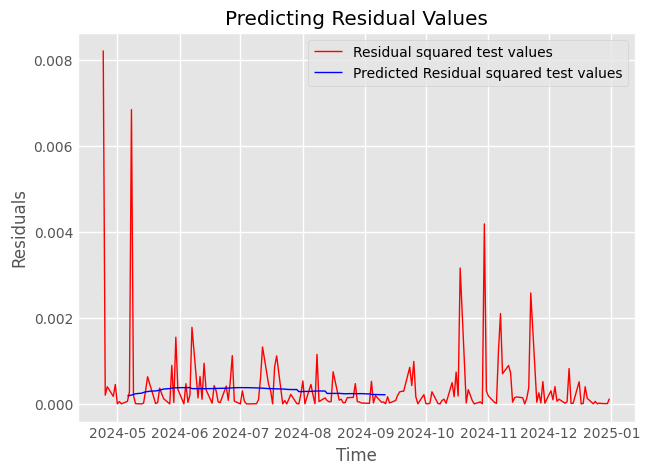

In [269]:
# Visualizing the results for LSTM
plot_predictions(residuals_squared_test,predicted_stock_price_df['Predicted'])

In [270]:
# Evaluating our model
return_rmse(residuals_squared_test[8:101],predicted_stock_price_df['Predicted'])

The root mean squared error is 0.0007761214398980895.


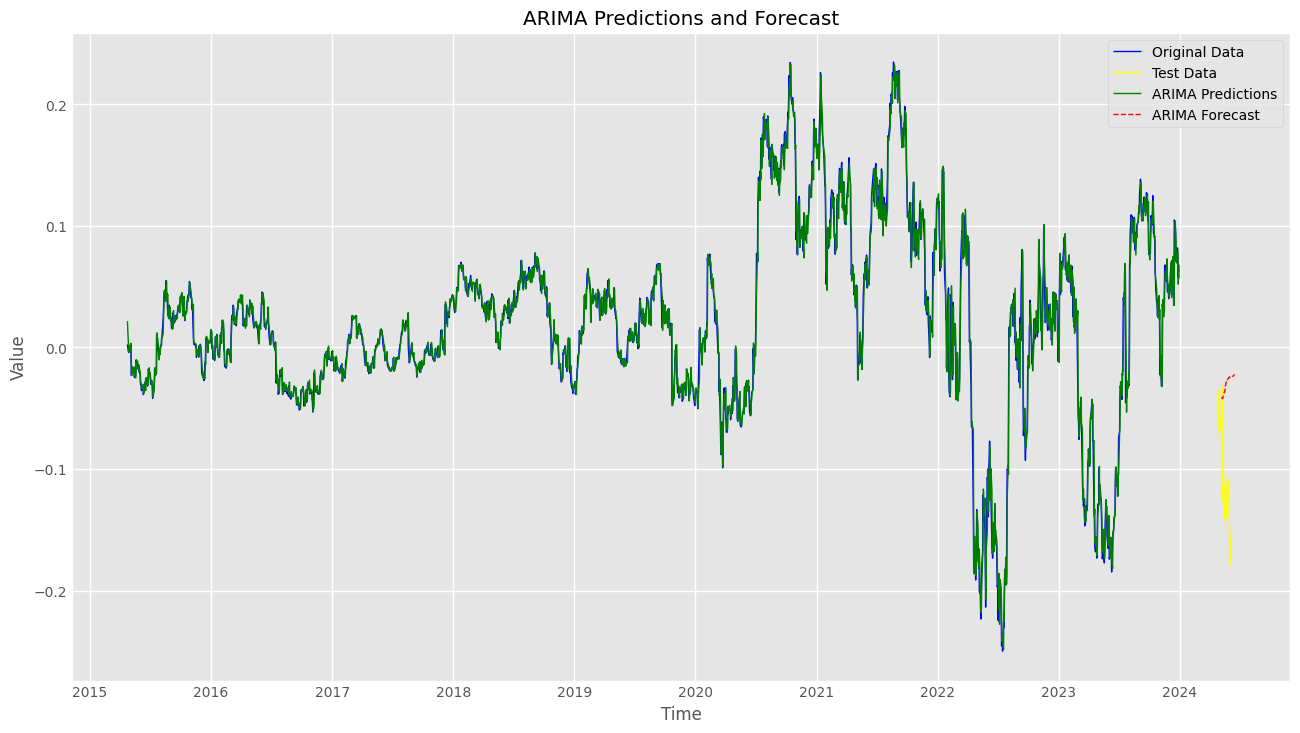

The calculated Root Mean Square Error (RMSE) is: 0.1003127352869813
The calculated Mean Absolute Error (MAE) is: 0.09455109164474917


In [273]:
models = {
    "ARIMA": (arima_pred, predicted_stock_price_df['Summed'])
}

for model_name, (predictions, forecast) in models.items():
    plt.figure(figsize=(14, 8))
    plt.plot(data_diff, label="Original Data", color="blue", linewidth = 1)
    plt.plot(test_diff[:30], label='Test Data', color="yellow", linewidth = 1)
    plt.plot(predictions, label=f"{model_name} Predictions", color="green", linewidth = 1)
    plt.plot(
        forecast[:30],
        label=f"{model_name} Forecast",
        color="red",
        linestyle="dashed",
        linewidth = 1
    )
    plt.title(f"{model_name} Predictions and Forecast")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    forecast_aligned, actual_aligned = forecast[:30].align(test_diff[:30], join='inner')
    meanSquaredError = ((forecast_aligned - actual_aligned) ** 2).mean()
    meanAbsError = (abs(forecast_aligned - actual_aligned)).mean()

    # Calculate the RMSE by taking the square root of the MSE
    rmse = np.sqrt(meanSquaredError)
    # Print the RMSE
    print("The calculated Root Mean Square Error (RMSE) is: " + str(rmse))
    print("The calculated Mean Absolute Error (MAE) is: " + str(meanAbsError))

In [ ]:
# one can see that the RMSE and MSE are lower in ARIMA-LSTM model than what we got in only ARIMA model. (had to subtract the residuals here to obtain optimal results)